In [4]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

imA = cv2.cvtColor(cv2.imread("A.png"), cv2.COLOR_BGR2GRAY)
imB = cv2.cvtColor(cv2.imread("B1.png"), cv2.COLOR_BGR2GRAY)

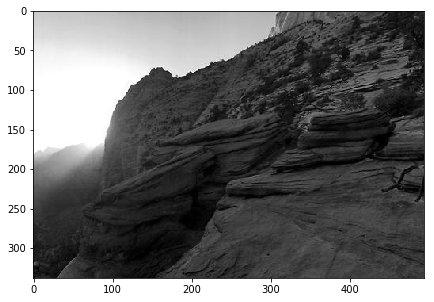

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(imA, 'gray')
plt.show()

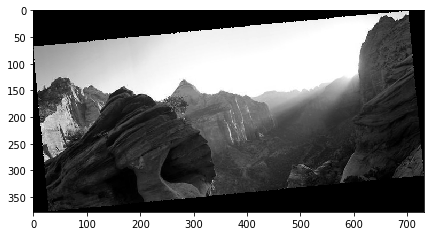

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(imB, 'gray')
plt.show()

In [7]:
sift = cv2.xfeatures2d.SIFT_create()

In [8]:
(kpsA, desA) = sift.detectAndCompute(imA, None)
(kpsB, desB) = sift.detectAndCompute(imB, None)

In [9]:
print("# kps: {}, descriptors: {}".format(len(kpsA), desA.shape))

# kps: 722, descriptors: (722, 128)


In [10]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(desA,desB,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

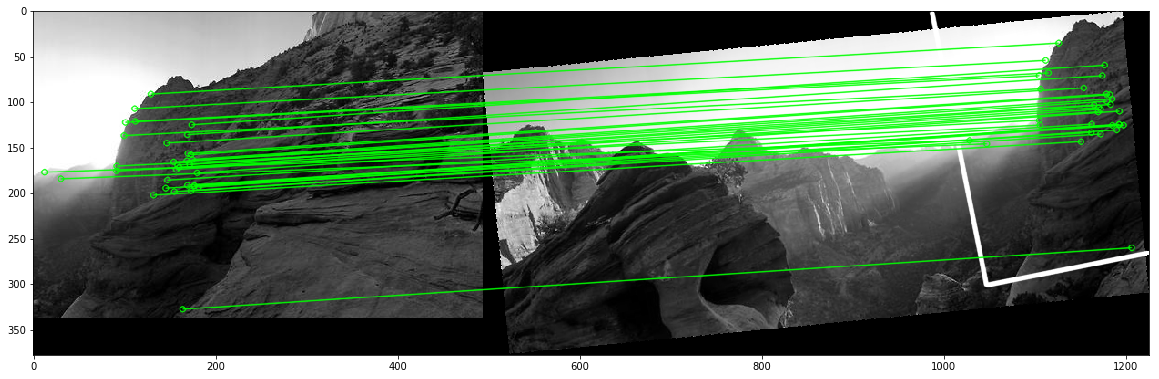

In [11]:
if len(good)>10:
    src_pts = np.float32([ kpsA[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kpsB[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = imA.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    _imB = cv2.polylines(imB,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found")
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

imC = cv2.drawMatches(imA,kpsA,imB,kpsB,good,None,**draw_params)

plt.figure(figsize=(20,10))
plt.imshow(imC, 'gray')
plt.show()